# Lending Tree

![](banner_lending_tree.jpg)

Kernel Density Estimation (KDE), Principal Component Analysis (PCA)

In [1]:
cat("Open code cell here for notebook apparatus.")

options(warn=-1)

# Load some required functions
library(plyr,      verbose=FALSE, warn.conflicts=FALSE, quietly=TRUE)
library(ggplot2,   verbose=FALSE, warn.conflicts=FALSE, quietly=TRUE)
library(gridExtra, verbose=FALSE, warn.conflicts=FALSE, quietly=TRUE)

# Set some visualization constants
PALETTE = c("#00A9FF", "#F8766D", "#7CAE00", "#C77CFF", "#CD9600", "#00BE67", "#FF61CC", "#00BFC4")
theme.x_axis_only = theme(axis.title.y=element_blank(), axis.text.y=element_blank(), axis.ticks.y=element_blank(), panel.grid.major.y=element_blank(), panel.grid.minor.y=element_blank())
theme.no_axis_titles = theme(axis.title.x=element_blank(), axis.title.y=element_blank())
theme.x_axis_45 = theme(axis.text.x=element_text(angle=45, hjust=1, vjust=1))
theme.no_legend = theme(legend.position="none")

# define some useful functions
size = function(data) data.frame(observations=dim(data)[1], variables=dim(data)[2])
output = function(width, height) options(repr.plot.width=width, repr.plot.height=height)
output_restore = function() options(repr.plot.width=8, repr.plot.height=3)
num_columns = function(data) aaply(names(data), 1, function(j) { class(data[, j]) != "factor" })
full_columns = function(data) aaply(names(data), 1, function(j) { !any(is.na(data[, j])) })
vary_columns = function(data) aaply(names(data), 1, function(j) { length(unique(data[, j])) > 1 })
sd_columns = function(data) aaply(1:ncol(data), 1, function(j) sd(data[,j]))
var_columns = function(data) aaply(1:ncol(data), 1, function(j) var(data[,j]))                                   
pc_constituents = function(pc) { pc_names = names(as.data.frame(pc$rotation))
                                 qual = as.data.frame(t(adply(pc_names, 1, function(j) row.names(pc$rotation)[rev(order(abs(pc$rotation[,j])))])[-1]))
                                 names(qual) = pc_names
                                 row.names(qual) = NULL
                                 qual }

# Set some visualization formatting defaults
output_restore()
options(repr.matrix.max.cols=74)
update_geom_defaults("point", list(size=0.01, colour=PALETTE[1]))
update_geom_defaults("vline", list(color="black", size=0.15))
update_geom_defaults("col", list(fill=PALETTE[1]))
update_geom_defaults("density", list(size=3, fill=PALETTE[1], colour=NA))
theme_update(plot.title=element_text(size=10, hjust=0.5), plot.subtitle=element_text(size=8, face="italic", hjust=0.5), axis.title=element_text(size=7), axis.text=element_text(size=7), strip.text=element_text(size=7), strip.text.y=element_text(angle=90), legend.title=element_blank(), legend.text=element_text(size=7))

Open code cell here for notebook apparatus.

## Situation

LendingTree is an online lending exchange that connects consumers with multiple lenders, banks, and credit partners who compete for business.  Since being founded in 1998 LendingTree has facilitated more than 32 million loan requests.

* **Role:** Banker. 
* **Business Decision:** Lend to whom?
* **Approach:** Use kernel density estimation and principal component transformation to look for features that distinguish known good vs. bad loans, and use that insight to inform decisions about new loans.  
* **Dataset:** Lending Tree Loans 2007-2010 ()

## Business Model

Lorem ipsum ...

## Data 

### Retrieve data.

In [2]:
datax = read.csv("Lending Tree Loans.csv") # may take about 2 minutes
size(datax)
head(datax)

observations,variables
887379,74


id      member_id loan_amnt funded_amnt funded_amnt_inv term       int_rate
1 1077501 1296599    5000      5000        4975            36 months 10.65   
2 1077430 1314167    2500      2500        2500            60 months 15.27   
3 1077175 1313524    2400      2400        2400            36 months 15.96   
4 1076863 1277178   10000     10000       10000            36 months 13.49   
5 1075358 1311748    3000      3000        3000            60 months 12.69   
6 1075269 1311441    5000      5000        5000            36 months  7.90   
  installment grade sub_grade emp_title                emp_length
1 162.87      B     B2                                 10+ years 
2  59.83      C     C4        Ryder                    < 1 year  
3  84.33      C     C5                                 10+ years 
4 339.31      C     C1        AIR RESOURCES BOARD      10+ years 
5  67.79      B     B5        University Medical Group 1 year    
6 156.46      A     A4        Veolia Transportaton     3 years   
  home_ownership annual_inc verification_status issue_d  loan_status pymnt_plan
1 RENT           24000      Verified            Dec-2011 Fully Paid  n         
2 RENT           30000      Source Verified     Dec-2011 Charged Off n         
3 RENT           12252      Not Verified        Dec-2011 Fully Paid  n         
4 RENT           49200      Source Verified     Dec-2011 Fully Paid  n         
5 RENT           80000      Source Verified     Dec-2011 Current     n         
6 RENT           36000      Source Verified     Dec-2011 Fully Paid  n         
  url                                                                 
1 https://www.lendingclub.com/browse/loanDetail.action?loan_id=1077501
2 https://www.lendingclub.com/browse/loanDetail.action?loan_id=1077430
3 https://www.lendingclub.com/browse/loanDetail.action?loan_id=1077175
4 https://www.lendingclub.com/browse/loanDetail.action?loan_id=1076863
5 https://www.lendingclub.com/browse/loanDetail.action?loan_id=1075358
6 https://www.lendingclub.com/browse/loanDetail.action?loan_id=1075269
  desc                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
1   Borrower added on 12/22/11 > I need to upgrade my business technologies.<br>                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
2   Borrower added on 12/22/11 > I plan to use this money to finance the motorcycle i am looking at. I plan to have it paid off as soon as possible/when i sell my old bike. I only need this money because the deal im looking at is to good to pass up.<br><br>  Borrower added on 12/22/11 > I plan to use this money to finance the motorcycle i am looking at. I plan to have it paid off as soon as possible/when i sell my old bike.I only need this money because the deal im looking at is to good to pass up. I have finished college with an associates degree in business and its takingmeplaces<br>
3                                                                                                                                                             

### Restrict analysis to inactive loans.  

Note which loans whether or not they were paid back.

In [3]:
as.data.frame(unique(datax$loan_status))

unique(datax$loan_status)
Fully Paid
Charged Off
Current
Default
Late (31-120 days)
In Grace Period
Late (16-30 days)
Does not meet the credit policy. Status:Fully Paid
Does not meet the credit policy. Status:Charged Off
Issued


In [4]:
good = which(datax$loan_status %in% c("Fully Paid", "Does not meet the credit policy. Status:Fully Paid"))
data.frame(good_observations=length(good))

good_observations
209711


In [5]:
bad = which(datax$loan_status %in% c("Default", "Charged Off", "Does not meet the credit policy. Status:Charged Off"))
data.frame(bad_observations=length(bad))

bad_observations
47228


### Restrict analysis to some convenient, well-represented variables.

In [7]:
str(datax[c(good,bad),])

'data.frame':	256939 obs. of  74 variables:
 $ id                         : int  1077501 1077175 1076863 1075269 1072053 1070078 1069908 1069866 1069759 1065775 ...
 $ member_id                  : int  1296599 1313524 1277178 1311441 1288686 1305201 1305008 1304956 1304871 1299699 ...
 $ loan_amnt                  : num  5000 2400 10000 5000 3000 6500 12000 3000 1000 10000 ...
 $ funded_amnt                : num  5000 2400 10000 5000 3000 6500 12000 3000 1000 10000 ...
 $ funded_amnt_inv            : num  4975 2400 10000 5000 3000 ...
 $ term                       : Factor w/ 2 levels " 36 months"," 60 months": 1 1 1 1 1 2 1 1 1 1 ...
 $ int_rate                   : num  10.6 16 13.5 7.9 18.6 ...
 $ installment                : num  162.9 84.3 339.3 156.5 109.4 ...
 $ grade                      : Factor w/ 7 levels "A","B","C","D",..: 2 3 3 1 5 3 2 2 4 3 ...
 $ sub_grade                  : Factor w/ 35 levels "A1","A2","A3",..: 7 15 11 4 21 13 10 6 16 14 ...
 $ emp_title               

Which columns are numeric and which are categorical?

In [8]:
n = num_columns(datax[c(good,bad),])
as.vector(which(n))
as.vector(which(!n))

[1]  1  2  3  4  5  7  8 14 25 26 28 29 30 31 32 33 34 35 37 38 39 40 41 42 43
[26] 44 45 47 50 51 52 54 55 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73
[51] 74

[1]  6  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24 27 36 46 48 49 53 56

Which columns are complete and which are incomplete (have missing data)?

In [9]:
f = full_columns(datax[c(good,bad),])
as.vector(which(f))
as.vector(which(!f))

[1]  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24 25 27
[26] 33 36 37 38 39 40 41 42 43 44 45 46 47 48 49 52 53 56

[1] 14 26 28 29 30 31 32 34 35 50 51 54 55 57 58 59 60 61 62 63 64 65 66 67 68
[26] 69 70 71 72 73 74

Which columns have at least some variation and which have no variation (all the same value)?

In [10]:
v = vary_columns(datax[c(good,bad),])
as.vector(which(v))
as.vector(which(!v))

[1]  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
[26] 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50
[51] 51 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74

[1] 52

Just the numeric, varying columns without any missing values.  Also omit the ID and Member ID variables.

In [11]:
data = datax[c(good,bad), n & f & v]
data = data[, -which(names(data) %in% c("id","member_id"))]

data.good = head(data, length(good))
data.bad  = tail(data, length(bad))

size(data)
head(data)

observations,variables
256939,17


,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,dti,revol_bal,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt
1,5000,5000,4975,10.65,162.87,27.65,13648,0,0,5861.071,5831.78,5000,861.07,0.00,0,0,171.62
3,2400,2400,2400,15.96,84.33,8.72,2956,0,0,3003.654,3003.65,2400,603.65,0.00,0,0,649.91
4,10000,10000,10000,13.49,339.31,20.00,5598,0,0,12226.302,12226.30,10000,2209.33,16.97,0,0,357.48
6,5000,5000,5000,7.90,156.46,11.20,7963,0,0,5631.378,5631.38,5000,631.38,0.00,0,0,161.03
8,3000,3000,3000,18.64,109.43,5.35,8221,0,0,3938.144,3938.14,3000,938.14,0.00,0,0,111.34
11,6500,6500,6500,14.65,153.45,16.12,4032,0,0,7677.520,7677.52,6500,1177.52,0.00,0,0,1655.54


<br>



## Transform to Principal Components

### Data expressed in terms of principal components.

In [86]:
pc = prcomp(data, scale=TRUE, retx=TRUE)

In [87]:
data.pc = as.data.frame(pc$x)

data.pc.good = head(data.pc, length(good))
data.pc.bad  = tail(data.pc, length(bad))

size(data.pc)
head(data.pc)

observations,variables
256939,17


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17
1,-2.6728263,-0.14654669,0.04509338,0.84197504,0.86961638,-0.3897855,-0.52941719,0.77489437,0.4203098,-0.05366822,-0.02494891,-0.02572467,0.005979817,0.002319907,0.0012539806,-3.604328e-06,-1.113028e-07
3,-3.4690408,-0.16861557,-0.01284539,-0.07781788,-0.78319987,0.5919857,0.60076570,-0.57595973,0.1728710,0.06792048,-0.09066727,-0.04246230,0.017233765,0.001567223,0.0006854618,3.993062e-07,-2.858595e-07
4,-0.9233908,0.32278031,-0.18535118,0.63275261,-1.85268515,-2.1063312,-0.87360502,0.31798500,0.3868079,0.14521962,-0.30808815,-0.05868274,0.031431236,-0.001114530,0.0019064534,-1.420421e-06,-1.714732e-07
6,-2.8601307,-0.55305043,0.11212335,-0.99704858,0.05895153,-0.2607079,0.22051480,0.49534723,0.2642117,-0.12021114,0.09505702,-0.01874722,0.027703971,0.003823135,0.0011371955,-6.281709e-07,1.743168e-07
8,-3.1631177,-0.04162375,-0.05769071,0.04282979,-1.08693439,0.7352626,1.15609335,-0.93231859,0.1285576,0.20220345,-0.22822293,-0.07149732,0.019017925,0.001592201,0.0008000824,8.830110e-07,-3.394440e-07
11,-2.2223630,-0.18280123,0.01600601,0.28141294,-0.32690755,0.3858523,0.03597171,0.01861758,0.2733875,0.04458815,-0.11911585,-0.24631975,-0.010939747,0.009479290,0.0034006300,-2.054884e-06,-1.084900e-09


### Qualitative interpretation of principal components.

Each column contains variable names sorted by weight applied to the principal component.

In [88]:
pc_constituents(pc)

PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17
funded_amnt,recoveries,out_prncp,dti,total_rec_late_fee,total_rec_late_fee,revol_bal,last_pymnt_amnt,total_rec_int,recoveries,total_rec_int,installment,funded_amnt_inv,loan_amnt,funded_amnt,out_prncp_inv,total_pymnt
loan_amnt,collection_recovery_fee,out_prncp_inv,int_rate,revol_bal,revol_bal,dti,int_rate,collection_recovery_fee,collection_recovery_fee,last_pymnt_amnt,funded_amnt_inv,total_pymnt_inv,funded_amnt,total_pymnt_inv,out_prncp,total_rec_prncp
funded_amnt_inv,out_prncp,recoveries,collection_recovery_fee,dti,int_rate,last_pymnt_amnt,total_rec_int,installment,last_pymnt_amnt,recoveries,loan_amnt,loan_amnt,total_pymnt_inv,funded_amnt_inv,funded_amnt,total_rec_int
total_pymnt,out_prncp_inv,collection_recovery_fee,total_rec_int,int_rate,dti,total_rec_int,dti,total_pymnt,total_rec_int,total_rec_prncp,funded_amnt,funded_amnt,funded_amnt_inv,total_rec_prncp,total_pymnt_inv,recoveries
total_pymnt_inv,int_rate,int_rate,recoveries,total_rec_int,last_pymnt_amnt,total_rec_late_fee,revol_bal,funded_amnt,installment,collection_recovery_fee,last_pymnt_amnt,total_rec_prncp,total_rec_prncp,total_pymnt,funded_amnt_inv,total_rec_late_fee
installment,total_rec_prncp,total_rec_late_fee,revol_bal,collection_recovery_fee,total_rec_int,int_rate,total_rec_late_fee,funded_amnt_inv,int_rate,total_pymnt_inv,total_rec_int,total_pymnt,total_pymnt,loan_amnt,total_rec_prncp,funded_amnt
total_rec_prncp,last_pymnt_amnt,last_pymnt_amnt,total_rec_prncp,last_pymnt_amnt,recoveries,collection_recovery_fee,collection_recovery_fee,total_pymnt_inv,total_rec_prncp,total_pymnt,total_pymnt_inv,installment,total_rec_int,total_rec_int,total_pymnt,loan_amnt
total_rec_int,total_rec_late_fee,total_rec_prncp,total_rec_late_fee,recoveries,collection_recovery_fee,total_rec_prncp,installment,loan_amnt,total_pymnt,int_rate,total_rec_prncp,total_rec_int,installment,recoveries,total_rec_int,out_prncp_inv
last_pymnt_amnt,total_rec_int,total_rec_int,out_prncp_inv,total_pymnt,installment,recoveries,loan_amnt,total_rec_prncp,total_pymnt_inv,loan_amnt,int_rate,recoveries,recoveries,installment,installment,out_prncp
revol_bal,total_pymnt_inv,total_pymnt_inv,out_prncp,total_pymnt_inv,total_pymnt_inv,total_pymnt_inv,funded_amnt,last_pymnt_amnt,dti,funded_amnt,recoveries,last_pymnt_amnt,last_pymnt_amnt,last_pymnt_amnt,loan_amnt,total_pymnt_inv


### Scree plot of principal components.

variable,sdev,variance,cum_variance,relative_variance,cum_relative_variance
PC1,2.717310e+00,7.383773e+00,7.383773,4.343396e-01,0.4343396
PC2,1.472142e+00,2.167201e+00,9.550974,1.274824e-01,0.5618220
PC3,1.409561e+00,1.986863e+00,11.537837,1.168743e-01,0.6786963
PC4,1.074064e+00,1.153614e+00,12.691450,6.785962e-02,0.7465559
PC5,1.025228e+00,1.051093e+00,13.742543,6.182899e-02,0.8083849
PC6,9.839737e-01,9.682042e-01,14.710747,5.695319e-02,0.8653381
PC7,8.726487e-01,7.615158e-01,15.472263,4.479505e-02,0.9101331
PC8,8.007444e-01,6.411915e-01,16.113455,3.771715e-02,0.9478503
PC9,6.959905e-01,4.844027e-01,16.597857,2.849428e-02,0.9763445
PC10,4.282901e-01,1.834324e-01,16.781290,1.079014e-02,0.9871347


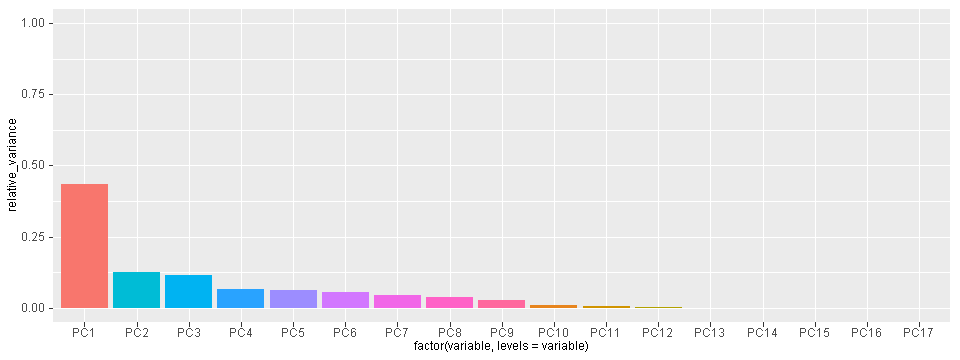

In [89]:
variable = names(data.pc)
sdev = sd_columns(data.pc)
variance = var_columns(data.pc)
cum_variance = cumsum(variance)
relative_variance = variance / sum(variance)
cum_relative_variance = cumsum(relative_variance)

scree.pc = data.frame(variable, sdev, variance, cum_variance, relative_variance, cum_relative_variance)
scree.pc

ggplot(scree.pc) + ylim(0,1) +
geom_col(aes(x=factor(variable, levels=variable), y=relative_variance, fill=variable)) +
theme.no_legend

## Predictive Models

### Naive Bayes

In [ ]:
model.nb = naiveBayes(class ~ x1+x2+x3, data)
model.nb

## Discussion

* Can you interpret the meaning of the principal components?
* Can you use principal component transformation to distinguish observations?
* Can you use principal component transformation to inform a business decision?

$\tiny \text{Copyright (c) Berkeley Data Analytics Group, LLC}$